In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import cv2
import matplotlib.pyplot as plt

In [3]:
from torch.autograd import Variable

In [4]:
PATH = Path("/home/ubuntu/hw2-image-classification-groverpr/")
list(PATH.iterdir())

[PosixPath('/home/ubuntu/hw2-image-classification-groverpr/.git'),
 PosixPath('/home/ubuntu/hw2-image-classification-groverpr/invasive_species_monitoring.ipynb'),
 PosixPath('/home/ubuntu/hw2-image-classification-groverpr/train_labels.csv'),
 PosixPath('/home/ubuntu/hw2-image-classification-groverpr/train'),
 PosixPath('/home/ubuntu/hw2-image-classification-groverpr/mode_tmp.pth'),
 PosixPath('/home/ubuntu/hw2-image-classification-groverpr/__MACOSX'),
 PosixPath('/home/ubuntu/hw2-image-classification-groverpr/model.pth'),
 PosixPath('/home/ubuntu/hw2-image-classification-groverpr/test'),
 PosixPath('/home/ubuntu/hw2-image-classification-groverpr/model2.pth'),
 PosixPath('/home/ubuntu/hw2-image-classification-groverpr/.ipynb_checkpoints'),
 PosixPath('/home/ubuntu/hw2-image-classification-groverpr/model3.pth'),
 PosixPath('/home/ubuntu/hw2-image-classification-groverpr/submissions')]

In [5]:
! ls train/ | head

1000.jpg
1001.jpg
1002.jpg
1003.jpg
1004.jpg
1005.jpg
1006.jpg
1007.jpg
1008.jpg
1009.jpg
ls: write error: Broken pipe


In [6]:
! head train_labels.csv

In [7]:
train_labels = pd.read_csv('train_labels.csv')

In [8]:
train_labels.name = train_labels.name.astype(str)+'.jpg'

In [9]:
train_labels[:2]

,name,invasive
0,1.jpg,0
1,2.jpg,0


In [10]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

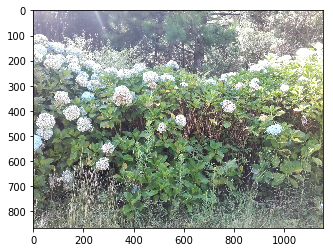

In [11]:
# example of imvasive

path = PATH/"train/3.jpg"
im = read_image(path)
plt.imshow(im)

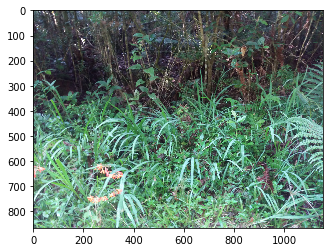

In [12]:
# example of non invasive

path = PATH/"train/1.jpg"
im = read_image(path)
plt.imshow(im)

In [13]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(866, 1154, 3)

In [14]:
# let's look at the typical size of these images
path = PATH/"train/"
files = list(path.iterdir())[:200]
dims = [read_image(str(p)).shape for p in files]
dims[:10]

[(866, 1154, 3),
 (866, 1154, 3),
 (866, 1154, 3),
 (866, 1154, 3),
 (866, 1154, 3),
 (866, 1154, 3),
 (866, 1154, 3),
 (866, 1154, 3),
 (866, 1154, 3),
 (866, 1154, 3)]

The size is same for all the images

## Data Augmentation

Data augmentation is the most important way to avoid overfitting for image classification tasks.

In [15]:
# modified from fast.ai
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center Crop

Text(0.5,1,'Center Cropped')

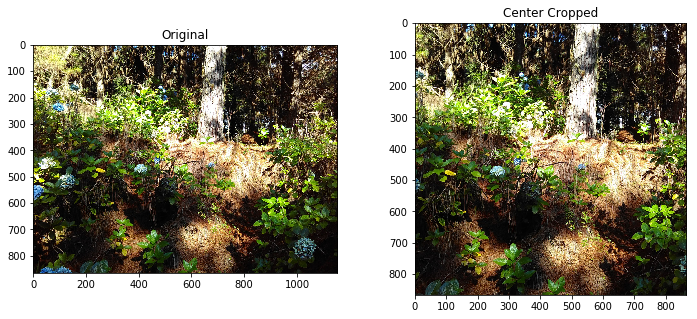

In [16]:
path = PATH/"train/1000.jpg"
im = read_image(path)
im2 = center_crop(im)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.imshow(im, cmap='gray')
ax1.set_title('Original')

ax2.imshow(im2, cmap='gray')
ax2.set_title("Center Cropped")

### Resize, horizontal and vertical translations

Text(0.5,1,'Resized')

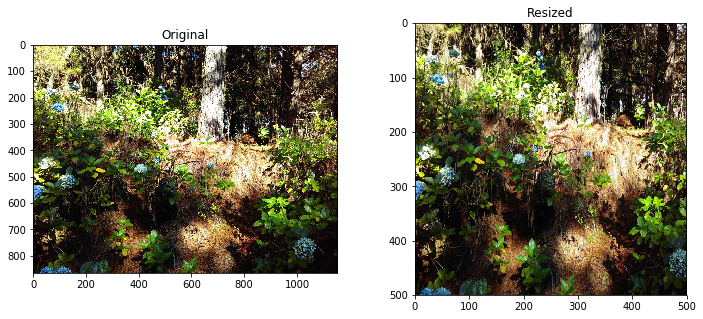

In [17]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing

path = PATH/"train/1000.jpg"
im = read_image(path)
im2 = cv2.resize(im, (550, 550))
im2 = random_crop(im2, 500, 500)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.imshow(im, cmap='gray')
ax1.set_title('Original')

ax2.imshow(im2, cmap='gray')
ax2.set_title("Resized")

### Random Rotation (-10, 10)

-3.7179540118955368


Text(0.5,1,'Rotated')

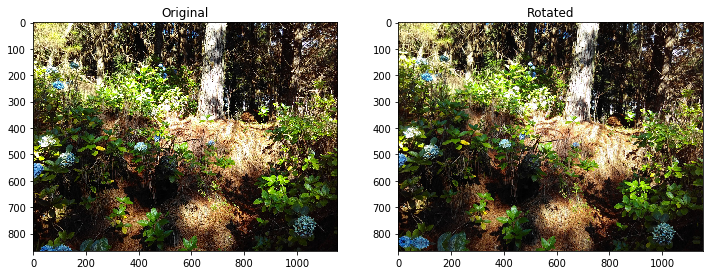

In [18]:
path = PATH/"train/1000.jpg"
im = read_image(path)

rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.imshow(im, cmap='gray')
ax1.set_title('Original')

ax2.imshow(im_rot, cmap='gray')
ax2.set_title("Rotated")

### Horizontal flip

Text(0.5,1,'Horizontal Flipped')

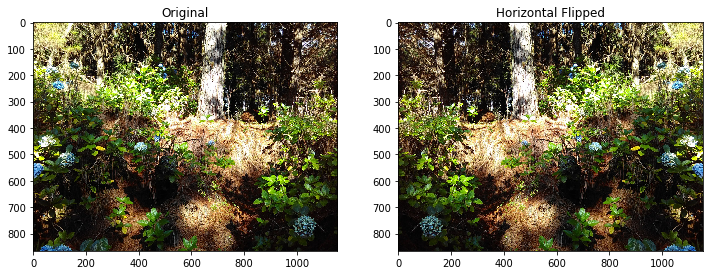

In [31]:
path = PATH/"train/1000.jpg"
im = read_image(path)
im_f = np.fliplr(im)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.imshow(im, cmap='gray')
ax1.set_title('Original')

ax2.imshow(im_f, cmap='gray')
ax2.set_title("Horizontal Flipped")

### Vertical flip

Text(0.5,1,'Vertical Flipped')

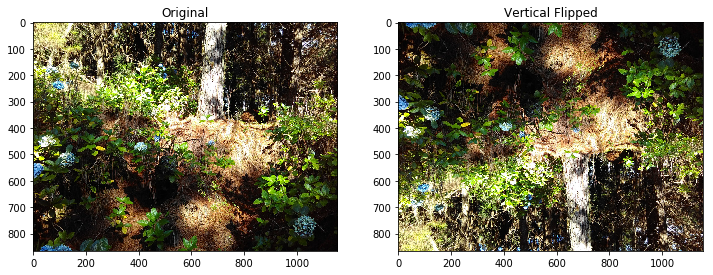

In [32]:
path = PATH/"train/1000.jpg"
im = read_image(path)
im_f = np.flipud(im)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.imshow(im, cmap='gray')
ax1.set_title('Original')

ax2.imshow(im_f, cmap='gray')
ax2.set_title("Vertical Flipped")

## Dataset

Train-val split

In [19]:
np.random.seed(32)

In [20]:
val_idx = np.random.choice(list(train_labels.index), int(train_labels.shape[0]*0.2)) 

In [21]:
trn_idx = np.array([idx for idx in list(train_labels.index) if idx not in val_idx])

In [22]:
trn_idx.shape, val_idx.shape

((1875,), (459,))

In [23]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [67]:
class invasive_species(Dataset):
    def __init__(self, PATH, train="train", label_df = train_labels, transforms=False, sz=224):
        self.path_to_images = PATH/train
        self.transforms = transforms
        self.sz = sz
        self.sz2 = int(sz*1.05)
        self.files = [self.path_to_images/i for i in label_df['name']]
        self.y = label_df['invasive']

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        path = str(self.files[idx]) 
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        # center crop
        x = center_crop(x)
        if self.transforms:
            x = cv2.resize(x, (self.sz2, self.sz2))
            x = random_crop(x, self.sz, self.sz)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (self.sz, self.sz))
        # substract numbers from resnet34
        x = normalize(x)
        return np.rollaxis(x, 2), self.y[idx]

In [25]:
train_ds = invasive_species(PATH, label_df=train_labels.iloc[trn_idx,:],transforms=True)

In [26]:
val_ds = invasive_species(PATH, label_df=train_labels.iloc[val_idx,:],transforms=False)

In [27]:
len(train_ds)

2295

In [28]:
batch_size  = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(val_ds, batch_size=batch_size)

In [28]:
x,y = next(iter(train_dl))

In [29]:
x.shape

torch.Size([64, 3, 224, 224])

In [30]:
y.shape

torch.Size([64])

### Model

In [29]:
# resnet
resnet = models.resnet34(pretrained=True)

In [30]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]  # last 2 layers

10


[AvgPool2d(kernel_size=7, stride=1, padding=0, ceil_mode=False, count_include_pad=True),
 Linear(in_features=512, out_features=1000, bias=True)]

In [31]:
layers[-1:]

[Linear(in_features=512, out_features=1000, bias=True)]

In [92]:
layers[-3:-2]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
   )
   (2): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_

In [93]:
# n observations, n_channels, H, W

x = torch.randn(1, 3, 7, 7)

In [94]:
x


(0 ,0 ,.,.) = 
 -0.2476  0.0990 -0.2297  0.5668 -0.0099  0.0020  1.0185
 -0.0684 -0.5801 -0.8067 -0.5897  0.7777 -0.5626  1.3838
  0.2109 -1.8575 -1.4124  0.5874 -0.3645 -1.7662  0.0840
 -0.4888  1.6601  0.9110 -0.0572 -0.6245 -1.3994 -0.8763
 -2.1415  0.6910  1.7028  1.5497  0.6785 -0.8745  0.3620
  1.5331  0.8729 -1.2120  0.2281  1.8446  0.8899  0.3528
 -1.1456 -0.8245  0.5711 -1.1080  0.5894 -0.6980 -2.2875

(0 ,1 ,.,.) = 
 -1.3215 -0.5918 -0.7953 -1.1457  1.2803 -1.3085 -0.6777
 -1.1669  0.4812  0.6125 -1.0007  0.5822 -0.2635  0.5227
  0.2368  0.6804 -1.4865 -1.5472 -1.9506  0.6666 -0.5853
 -0.1309  1.8495  1.0442 -0.7766 -0.3908  0.1155  0.1487
 -0.1251  0.0154  0.5689 -1.3363 -0.1314  0.9610  0.1209
 -0.8020  0.8865  0.3773  0.1083  1.9988 -0.3360 -0.0769
 -0.2150 -0.8711 -0.5466  0.1260 -1.6580 -0.2316 -0.1829

(0 ,2 ,.,.) = 
 -1.6555 -0.5215 -0.4119  0.5415  2.1952  1.9780 -3.1028
  0.1569 -0.2532  0.5937 -0.2357  0.9117 -0.0257  0.9806
 -0.7553 -2.6299  1.3368  0.6798  1.6352

In [95]:
## Understanding adaptive pooling

m1 = nn.AvgPool2d(kernel_size=7, stride=7, padding=0)
i1 = Variable(x)
o1 = m1(i1)
o1.shape

torch.Size([1, 3, 1, 1])

In [96]:
o1

Variable containing:
(0 ,0 ,.,.) = 
 -0.0626

(0 ,1 ,.,.) = 
 -0.1688

(0 ,2 ,.,.) = 
  0.1557
[torch.FloatTensor of size 1x3x1x1]

In [97]:
m2 = nn.AdaptiveAvgPool2d((1,1))
i2 = Variable(x)
o2 = m2(i1)
o2.shape

torch.Size([1, 3, 1, 1])

In [98]:
o2.view(3,1)

Variable containing:
-0.0626
-0.1688
 0.1557
[torch.FloatTensor of size 3x1]

In [99]:
st= np.std(o2.view(3,1).data.numpy())
mean = np.mean(o2.view(3,1).data.numpy())

In [100]:
st, mean

(0.13505043, -0.025219461)

In [101]:
( 0.1453 - mean)/st

1.262635445297245

In [102]:
bn1 = nn.BatchNorm1d(1)

In [103]:
bn1(o2.view(3,1))

Variable containing:
-0.2693
-1.0347
 1.3040
[torch.FloatTensor of size 3x1]

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8] # only first 8 layers
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x) # only get 1 activations per channel
        x = x.view(x.shape[0], -1) # flattening 
        #x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [32]:
model = Net().cuda()

In [37]:
x, y = next(iter(train_dl))

In [38]:
x = x.cuda().float()
y = y.cuda().float()
x.shape,y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [39]:
# output upto last 2 layers of resnet. frozen 
x_features = model.top_model(Variable(x))
x_features.shape 

torch.Size([64, 512, 7, 7])

In [115]:
# AdaptiveAvgPool2d would do a similar job if the input is [64, 512, 10, 20]
# that is why this model will fit any input size
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

In [116]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([64, 512])

In [118]:
y_hat = model(Variable(x))
y_hat.shape

torch.Size([64, 1])

In [125]:
y_hat.min(), y_hat.max()

(Variable containing:
 -0.7464
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.6848
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [145]:
# This loss combines a Sigmoid layer and the BCELoss in one single class. see
# https://pytorch.org/docs/master/nn.html#torch.nn.BCEWithLogitsLoss
F.binary_cross_entropy_with_logits(y_hat, Variable(y.unsqueeze(1)))

Variable containing:
 0.7276
[torch.cuda.FloatTensor of size 1 (GPU 0)]

### Trying adaptive maxpooling for different input size

In [33]:
batch_size = 64
val_ds_100 = invasive_species(PATH, label_df=train_labels.iloc[val_idx,:],transforms=False, sz=100)
val_dl_100 = DataLoader(val_ds_100, batch_size=batch_size)

In [148]:
x, y = next(iter(val_dl_100))
x.shape

torch.Size([64, 3, 100, 100])

In [150]:
x = x.cuda().float()
x_features = model.top_model(Variable(x))
x_features.shape

torch.Size([64, 512, 4, 4])

In [151]:
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

## LR Finder

In [34]:
batch_size  = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size)

In [35]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [36]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=5):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda().float().unsqueeze(1)
            out = model(Variable(x))
            loss = F.binary_cross_entropy_with_logits(out, Variable(y))
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.data[0])
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses

In [182]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.05)

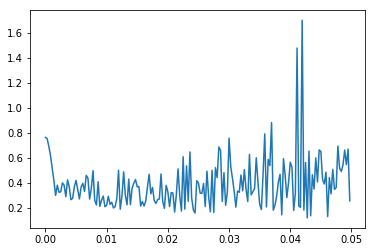

In [183]:
plt.plot(lrs, losses)
plt.show()

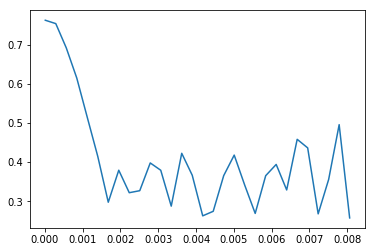

In [189]:
plt.plot(lrs[:30], losses[:30])
plt.show()

In [185]:
len(lrs)

180

## Triangular LR 

In [37]:
def get_triangular_lr2(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

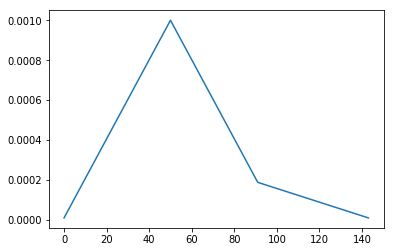

In [49]:
plt.plot(get_triangular_lr2(1e-5, 0.001, 2*len(train_dl)))

In [38]:
def train_triangular_policy(model, train_dl, val_dl, lr_low=1e-5, lr_high=0.001):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float().unsqueeze(1)
            out = model(Variable(x))
            loss = F.binary_cross_entropy_with_logits(out, Variable(y))
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.data[0])
        print("train loss", sum_loss/total)
        val_metrics(model, val_dl)
    return sum_loss/total

In [39]:
def val_metrics(model, val_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y) in enumerate(val_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().unsqueeze(1)
        out = model(Variable(x))
        pred = (out > 0.0).long()
        correct += (pred == Variable(y)).sum().data[0]
#         correct += pred.eq(Variable(y)).sum()
        y = y.float()
        loss = F.binary_cross_entropy_with_logits(out, Variable(y))
        sum_loss += batch*(loss.data[0])
        total += batch
    print("val loss and accuracy", sum_loss/total, correct/total)

## Training frozen layes with triangular LR

In [40]:
from datetime import datetime

def training_loop(model, train_dl, val_dl, steps=3, lr_low=1e-5, lr_high=0.001):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, val_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [41]:
batch_size  = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size)

In [53]:
model = Net().cuda()

In [222]:
# no training baseline
val_metrics(model, val_dl)

val loss and accuracy 0.6825247032450176 0.6152505446623093


In [223]:
training_loop(model, train_dl, val_dl, steps=1)

train loss 0.48530506141045515
val loss and accuracy 0.32021244783806646 0.881917211328976
train loss 0.25635299760531755
val loss and accuracy 0.2035250989115576 0.918954248366013
train loss 0.2154454002582949
val loss and accuracy 0.1928609624667365 0.9254901960784314
train loss 0.19868337830816737
val loss and accuracy 0.19038037040264777 0.9272331154684096
----End of step Time elapsed 0:10:20.395381


## Unfreezing resnet layers

### Unfreeze 6 and 7

In [224]:
# # save model
# def save_model(m, p): 
#     torch.save(m.state_dict(), p)
# p = PATH/"model.pth"
# save_model(model, p)

In [257]:
# load model
p = PATH/"model.pth"
model.load_state_dict(torch.load(p))

In [258]:
val_metrics(model, val_dl)

val loss and accuracy 0.19038037040264777 0.9272331154684096


In [54]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [55]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [261]:
# unfreezing 6th and 7th layer
unfreeze(model, 7)
unfreeze(model, 6) 

In [248]:
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1, epochs=5)

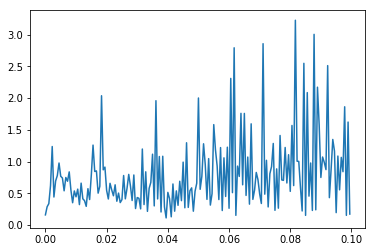

In [249]:
plt.plot(lrs, losses)
plt.show()

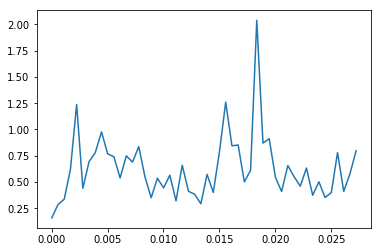

In [251]:
plt.plot(lrs[:50], losses[:50])
plt.show()

load and unfreeze model again before running below chunk

In [266]:
pa =  list(model.parameters())

In [271]:
pa[1].requires_grad

False

In [ ]:
p[7].requires.grad

In [272]:
train_triangular_policy(model, train_dl, val_dl, lr_low=1e-6, lr_high=0.0001) # fine tune weights with lower lr

train loss 0.18495950115791854
val loss and accuracy 0.2708383900991972 0.9202614379084967
train loss 0.11238742211999976
val loss and accuracy 0.051270846794470984 0.9808278867102397
train loss 0.043512875661416255
val loss and accuracy 0.044141640770198345 0.9864923747276688
train loss 0.03584088386890675
val loss and accuracy 0.03413027392006388 0.9877995642701525


0.03584088386890675

In [274]:
# # save model
# def save_model(m, p): 
#     torch.save(m.state_dict(), p)
# p = PATH/"model2.pth"
# save_model(model, p)

In [43]:
# load model
p = PATH/"model2.pth"
model.load_state_dict(torch.load(p))

Check AUC score now

In [282]:
batch_size = len(val_idx)
val_ds_all = invasive_species(PATH, label_df=train_labels.iloc[val_idx,:],transforms=False, sz=224)
val_dl_all = DataLoader(val_ds_all, batch_size=batch_size)

In [284]:
valx, valy = next(iter(val_dl_all))

In [285]:
valx.shape, valy.shape

(torch.Size([459, 3, 224, 224]), torch.Size([459]))

In [56]:
from sklearn.metrics import roc_auc_score

In [57]:
def auc_score(out, y):
    return roc_auc_score(to_np(y).ravel(), (to_np(out).ravel()))

def to_np(t):
    return t.data.cpu().numpy()

In [290]:
preds = model(Variable(valx.cuda().float()))

In [292]:
sig = F.sigmoid(preds)

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.4965472, -0.3965472, -0.2965472, -0.1965472, -0.0965472,
         0.0034528,  0.1034528,  0.2034528,  0.3034528,  0.4034528,
         0.5034528]),
 <a list of 10 Patch objects>)

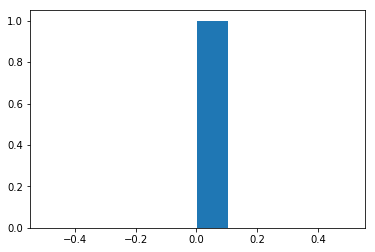

In [295]:
plt.hist(sig.data[0])

In [299]:
auc_score(sig, Variable(valy))

0.9997700668896321

## Submitting on Kaggle

In [64]:
! ls test | wc -l

1531


In [45]:
train_labels[:2]

,name,invasive
0,1.jpg,0
1,2.jpg,0


In [46]:
# making df for test data. the name of files are silimar to test just that there are `1531 files

test_df = train_labels.copy()
test_df = test_df.iloc[:1531,:]

In [47]:
test_df.shape

(1531, 2)

In [65]:
batch_size = 1531
test_ds_all = invasive_species(PATH,"test", label_df=test_df,transforms=False, sz=224)
test_dl_all = DataLoader(test_ds_all, batch_size=batch_size)

In [56]:
testx, testy = next(iter(test_dl_all))

In [57]:
testx.shape, testy.shape

(torch.Size([1531, 3, 224, 224]), torch.Size([1531]))

In [47]:
test_preds = model(Variable(testx.cuda().float()))

In [48]:
test_sig = F.sigmoid(test_preds)

In [52]:
preds = test_sig.data.cpu().numpy()

(array([554.,  70.,  41.,  33.,  26.,  22.,  19.,  26.,  31., 709.]),
 array([1.33105254e-06, 9.99992429e-02, 1.99997155e-01, 2.99995067e-01,
        3.99992979e-01, 4.99990890e-01, 5.99988802e-01, 6.99986714e-01,
        7.99984626e-01, 8.99982538e-01, 9.99980450e-01]),
 <a list of 10 Patch objects>)

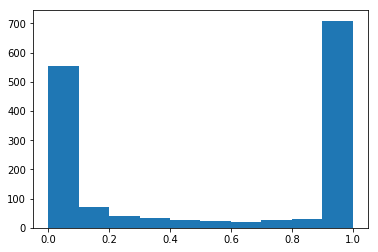

In [53]:
plt.hist(preds)

In [55]:
test_df.invasive = preds

In [67]:
test_df.name = np.arange(1,1532)

In [68]:
test_df[:2]

,name,invasive
0,1,0.997985
1,2,0.001686


In [69]:
test_df.to_csv('submissions/resnet1.csv', index=False)

In [70]:
from IPython.display import FileLink

In [71]:
FileLink('submissions/resnet1.csv')

/home/ubuntu/hw2-image-classification-groverpr/submissions/resnet1.csv

**submission score: 0.98371**

### Unfreeze 4 and 5

After unfreezing 4 and 5. I saved model2.pth. But code is lost somehow

In [41]:
# load model
p = PATH/"model3.pth"
model.load_state_dict(torch.load(p))

In [42]:
val_metrics(model, val_dl)

val loss and accuracy 0.024435789566000107 0.9938997821350762


### TTA 

In [62]:
test_df.shape

(1531, 2)

In [68]:
batch_size = 64
test_ds = invasive_species(PATH,"test", label_df=test_df,transforms=False, sz=224)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [69]:
batch_size = 64
test_ds_tm = invasive_species(PATH,"test", label_df=test_df,transforms=True, sz=224)
test_dl_tm = DataLoader(test_ds_tm, batch_size=batch_size, shuffle=False)

In [71]:
len(test_ds), len(test_ds_tm)

(1531, 1531)

In [72]:
def test_preds(model, test_dl):
    model.eval()
    total_preds = []
    for i, (x, y) in enumerate(test_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().unsqueeze(1)
        test_preds = model(Variable(x))
        test_sig = F.sigmoid(test_preds)
        preds = list(test_sig.data.cpu().numpy())        
        total_preds.append(preds)
    return total_preds

In [73]:
preds = test_preds(model, test_dl)

In [74]:
preds_tm = test_preds(model, test_dl_tm)

In [81]:
preds = [val for sublist in preds for val in sublist]

In [82]:
preds_tm = [val for sublist in preds_tm for val in sublist]

In [88]:
final_preds = np.mean((preds, preds_tm), axis=0)

In [89]:
test_df.invasive = final_preds

In [90]:
test_df.name = np.arange(1,1532)

In [91]:
test_df[:2]

,name,invasive
0,1,0.998346
1,2,0.000074


In [92]:
test_df.to_csv('submissions/resnet2.csv', index=False)

In [94]:
from IPython.display import FileLink

In [95]:
FileLink('submissions/resnet2.csv')

/home/ubuntu/hw2-image-classification-groverpr/submissions/resnet2.csv

**Submission score: 0.98492**

### End